In [1]:
import numpy as np
import matplotlib.pyplot as plot
import pandas as pd


In [2]:
import pyspark

try: 
    type(sc)
except NameError:
    sc = pyspark.SparkContext('local[*]')
    
import pyspark_csv as pycsv
sc.addPyFile('pyspark_csv.py')

In [3]:
import pyspark.sql as pysql

sqlCtx = pysql.SQLContext(sc)

trip_rdd=sc.textFile('trip.csv')
trips_df =pycsv.csvToDataFrame(sqlCtx,trip_rdd)

In [4]:
#el rdd de los trips
data=trips_df.rdd

In [7]:
#de la forma ( (start_station_id,end_station_id) , 1)  
frecuency=data.map(lambda x: ((x[4],x[7]),1) ).reduceByKey(lambda x,y:x+y).collect()

In [8]:
trips_df.registerTempTable('trips')

In [ ]:
max_index=sqlCtx.sql('select max(start_station_id) from trips').collect()


In [23]:
matrix=[ np.zeros(max_index[0][0]+1) for i in range(max_index[0][0]+1)]
for (row,col),val in frecuency:
    matrix[row][col]=val

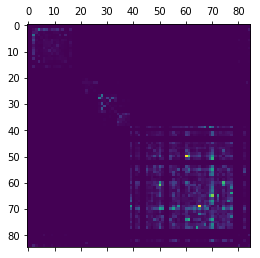

In [24]:
#Todas las estaciones(feo)
%matplotlib inline

plot.matshow(matrix)
plot.show()


In [36]:
#pandas_df
stations=pd.read_csv('station.csv')
stations_sf=sorted(stations.loc[stations.city=='San Francisco','id'].values)

In [58]:
frecuency_sf=data.filter(lambda x: (x[4]  in stations_sf) and(x[7]  in stations_sf) )\
            .map(lambda x: ((x[4],x[7]),1) )\
            .reduceByKey(lambda x,y:x+y).collect()
#frecuency_sf=trip

In [72]:
matrix_sf=[ np.zeros(len(stations_sf)) for i in range(len(stations_sf))]
for (start_id,end_id),val in frecuency_sf:
    row=stations_sf.index(start_id)
    col=stations_sf.index(end_id)
    matrix_sf[row][col]=val

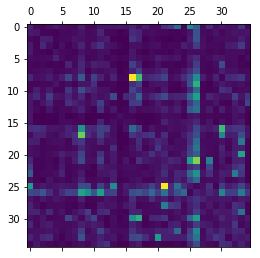

In [74]:
%matplotlib inline

plot.matshow(matrix_sf)
plot.show()

In [104]:
import plotly.plotly as py
import plotly.graph_objs as go


trace = go.Heatmap(
     x=stations.sort_values('id').loc[stations.city=='San Francisco', ['name']].values,
     y=stations.sort_values('id').loc[stations.city=='San Francisco', ['name']].values,
    z=matrix_sf,
    autocolorscale=True
)

layout = go.Layout(
    xaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=20 ),
    yaxis=dict( ticks='', showgrid=False, zeroline=False, nticks=20 ),
    autosize=True,
    height=850,
    width=850,
    hovermode='closest',

)
data = [trace]
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)
